# Exploring Gaussian Process Regression
> Gaussian Process Regression is robust forcasting and prediction tool. One particularly nice feature of this regression is that it contains output for the 'information' that it has derived, in this form, as a stdev metric. See http://scikit-learn.org/stable/modules/gaussian_process.html#gaussian-process for more information specific to the implementation used. 

### The application
> It should be no surprise that I've chosen to apply to this to the equities market but this time with a little twist, instead of predicting a price or direction, our objective will be to try and predict a price within the high-low band of the next days prices. We will only be using historical OHLC data and will be normalizing it with a log function to help remove long-term trends (which GPR is know for being bad at). This will be imperfect but we are just playing around, not trying to make millions :-)

In [1]:
# Imports
import pandas as pd
import numpy as np
pd.core.common.is_list_like = pd.api.types.is_list_like # adjustment for pandas version
from pandas_datareader import data as web
from sklearn.gaussian_process import GaussianProcessRegressor
# I know.
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Get Data & do a little exploration
def get_price(ticker):
    return web.DataReader(ticker, data_source='iex', start='7/1/2013')
raw_price = get_price('SPY')
# High level describe & head
print(raw_price.describe())
# Check Distribution
raw_price.hist(bins=10, layout=(1,5), figsize=(16,4));

5y
              open         high          low        close        volume
count  1259.000000  1259.000000  1259.000000  1259.000000  1.259000e+03
mean    207.269000   208.130146   206.336822   207.307385  1.018649e+08
std      34.443039    34.518771    34.340985    34.426282  4.824018e+07
min     147.871700   148.985800   147.681500   147.935100  2.785651e+07
25%     182.911250   184.015450   181.962200   182.927750  6.924178e+07
50%     197.462500   198.257000   196.610400   197.526200  9.034115e+07
75%     233.014350   233.438200   232.309850   233.013300  1.203651e+08
max     283.710000   284.370000   283.090000   284.161500  5.072443e+08


In [3]:
# Check last row
raw_price.iloc[-1]

open           280.81
high           282.02
low            280.38
close          281.33
volume    68570493.00
Name: 2018-07-31, dtype: float64

### Check-in
> So far, so good. We have all the prices for SPY and have wrapped them in a method for future use (you'll see why). Now we need to add a mid-point, and apply the log function to them.

In [4]:
# Constants
COLUMNS = ['open', 'high', 'low', 'close', 'mid']
PRED_COLUMN = 'mid'
# Looking one day forward
PRED_DISTANCE = -1
# Using the past 100 days prior
TRAINING_HISTORY_LENGTH = -100

In [5]:
# Data Wrangling
def adjust_prices(raw_price):
    raw_price['mid'] = raw_price['low'] + (raw_price['high'] - raw_price['low']) / 2
    log_prices = np.log(raw_price[COLUMNS])
    return log_prices.dropna()

prices_enh = adjust_prices(raw_price)
np.exp(prices_enh[-3:]), prices_enh[-3:]

(              open    high     low   close      mid
 date                                               
 2018-07-27  283.71  283.82  280.38  281.42  282.100
 2018-07-30  281.51  281.69  279.36  279.95  280.525
 2018-07-31  280.81  282.02  280.38  281.33  281.200,
                 open      high       low     close       mid
 date                                                        
 2018-07-27  5.647953  5.648340  5.636146  5.639848  5.642262
 2018-07-30  5.640168  5.640807  5.632501  5.634611  5.636663
 2018-07-31  5.637678  5.641978  5.636146  5.639528  5.639066)

### Check-in
> We have all our pricing, now the fun stuff. We will loop through each day/row and train the GPR model only using this historical data. Then we will pop in the current day/row and try and predict the middle/'mid' of the next day, recording that in our pred_ys for future exploration.

In [6]:
# Training and Prediction
def get_gpr_results(prices_enh):
    pred_ys = []
    sdev_ys = []
    # To get out-of-sample look-forward predictions we need to fit and predict only using historical
    for index, row in prices_enh[-1200:].iterrows():
        # drop non-relevant columns from current row
        row_restricted = row
        # Initialization of the GPR (don't want 'online' learning, yet)
        ol = GaussianProcessRegressor()
    
        # Restrict the 'history' so we have no look-ahead bias & drop volume 
        all_history = prices_enh[prices_enh.index < index][TRAINING_HISTORY_LENGTH:]

        # ensure no overlap with current row
        inputs = all_history[:-2]
    
        # get the information from the day ahead and realign
        y = all_history.copy().shift(PRED_DISTANCE)[PRED_COLUMN][:-2]
    
        ol.fit(inputs, y)
  
        resized_inputs_with_last_row = inputs[1:].append(row_restricted)
        prediction = ol.predict(resized_inputs_with_last_row, return_std=True)
        pred_ys.append(prediction[0][-1]) # grab the forward most prediction and add to array
        sdev_ys.append(prediction[1][-1]) # grab the forward most stdev and add to array

    # returns both pred and sdev
    return [pred_ys, sdev_ys]

    
pred_ys, sdev_ys = get_gpr_results(prices_enh)

### Check-in
> That takes a little time but we are running 1200 regressions, each with TRAINING_HISTORY_LENGTH (100) datapoints. Now let's remove the log application by applying the exp function and line up our predictions so that can compare them to the future. We will also see how frequently we are within our column of high-low.

In [7]:
def merge_results(prices_enh, pred_ys, sdev_ys):
    # Adjust to shape of pred_ys & merge everything together
    reduced_prices = prices_enh[-1*len(pred_ys):]
    reduced_prices['pred_ys'] = pred_ys
    reduced_prices['sdev_ys'] = sdev_ys

    # shift the forward prediction forward to do comparisons
    fully_shifted = np.exp(reduced_prices[['close','high','low', 'mid']])
    fully_shifted['zz_pred_y'] = np.exp(reduced_prices[['pred_ys']].shift(1))
    fully_shifted['zz_sdev_y'] = np.exp(reduced_prices[['sdev_ys']].shift(1))
    
    # see if they are within the channel
    fully_shifted['above'] = fully_shifted['zz_pred_y'] > fully_shifted['low']
    fully_shifted['below'] = fully_shifted['zz_pred_y'] < fully_shifted['high']
    fully_shifted['between'] = fully_shifted['above'] & fully_shifted['below']

    return fully_shifted

fully_shifted = merge_results(prices_enh, pred_ys, sdev_ys)

SPY:
         above     below   between
mean  0.694167  0.798333  0.493333


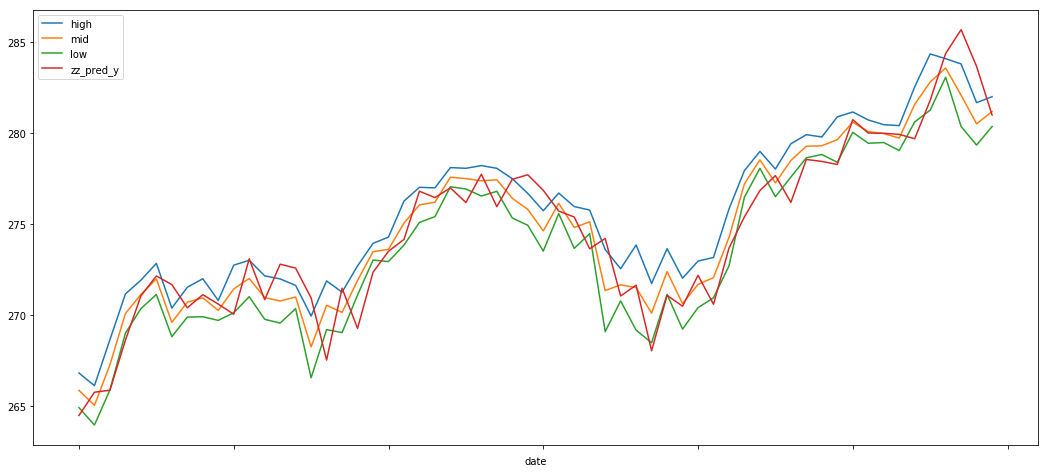

In [8]:
# A helper method to explore some of the outputs. Keeping it simple for now.
def quick_tear(symbol, fully_shifted):
    print("{}:".format(symbol))
    # convert bools to ints for % on mean
    print(fully_shifted[['above', 'below', 'between']].astype(int).describe().loc[['mean']])
    # plots the last 60 days for a visual
    fully_shifted[['high','mid', 'low', 'zz_pred_y']][-60:].plot(figsize=(18,8));

quick_tear('SPY',fully_shifted)

In [9]:
# put everything together to analyze new symbols
def analyze_symbol(symbol):
    raw_price = get_price(symbol)
    prices_enh = adjust_prices(raw_price)
    pred_ys, sdev_ys = get_gpr_results(prices_enh)
    fully_shifted = merge_results(prices_enh, pred_ys, sdev_ys)
    quick_tear(symbol, fully_shifted)
    return fully_shifted

### Check-in
> So our SPY analysis shows that we can be between the boundries 49.3% of the time. Certainly not great but we've applied no tweaks to the kernal and are using really basic data. No matter, what happens when we apply it to a handful of other tickers...

5y
T:
         above  below  between
mean  0.766667   0.79   0.5575
5y
F:
         above     below  between
mean  0.730833  0.770833   0.5025
5y
GE:
      above     below   between
mean   0.76  0.753333  0.514167
5y
AAPL:
         above   below   between
mean  0.680833  0.7625  0.444167
5y
TSLA:
      above  below   between
mean  0.735   0.73  0.465833
5y
CHK:
         above   below  between
mean  0.709167  0.6875   0.3975
5y
VAC:
         above     below  between
mean  0.735833  0.770833   0.5075
5y
NRG:
      above     below  between
mean   0.73  0.754167    0.485


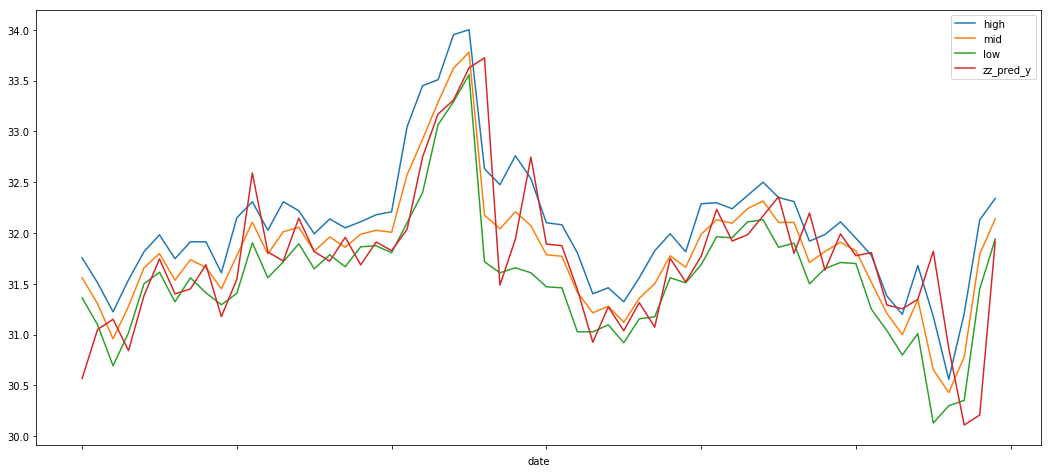

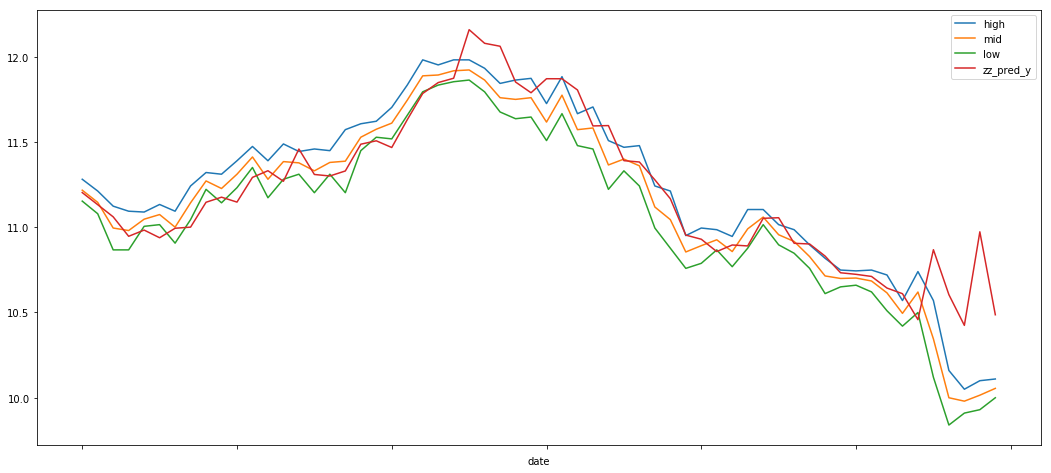

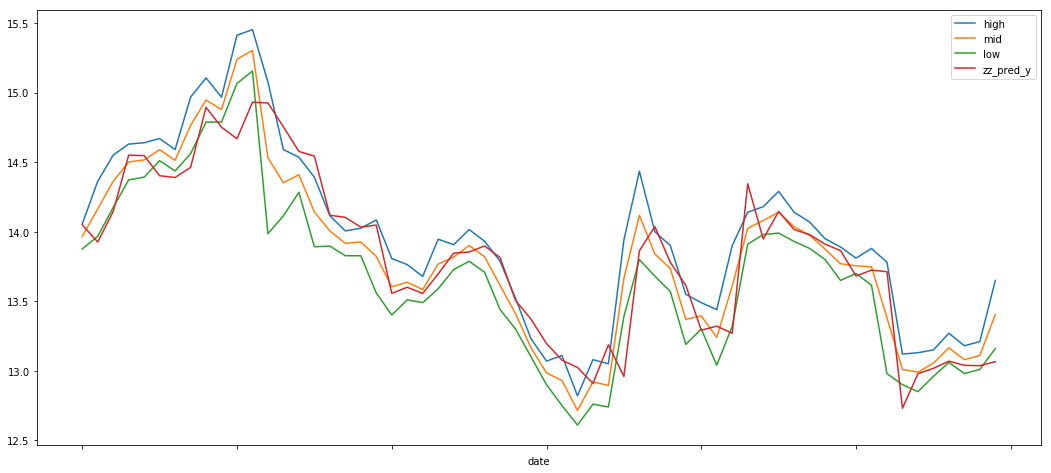

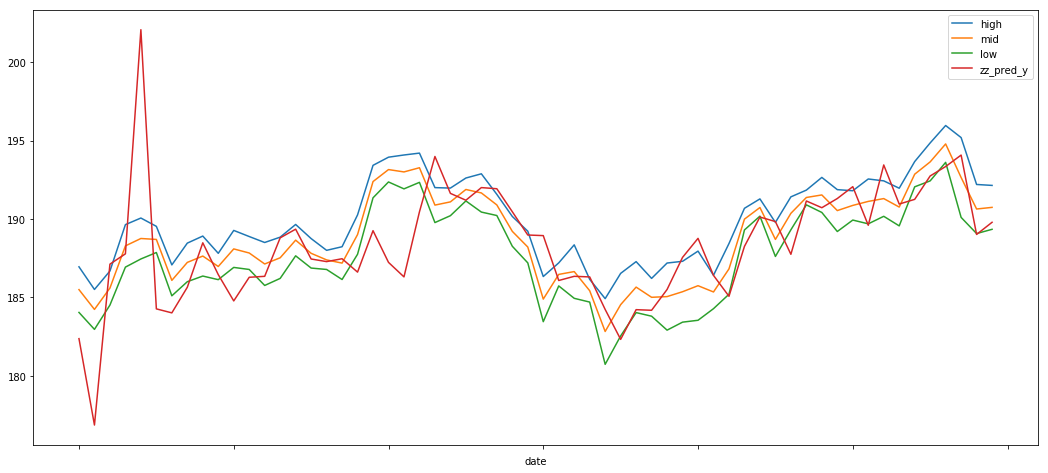

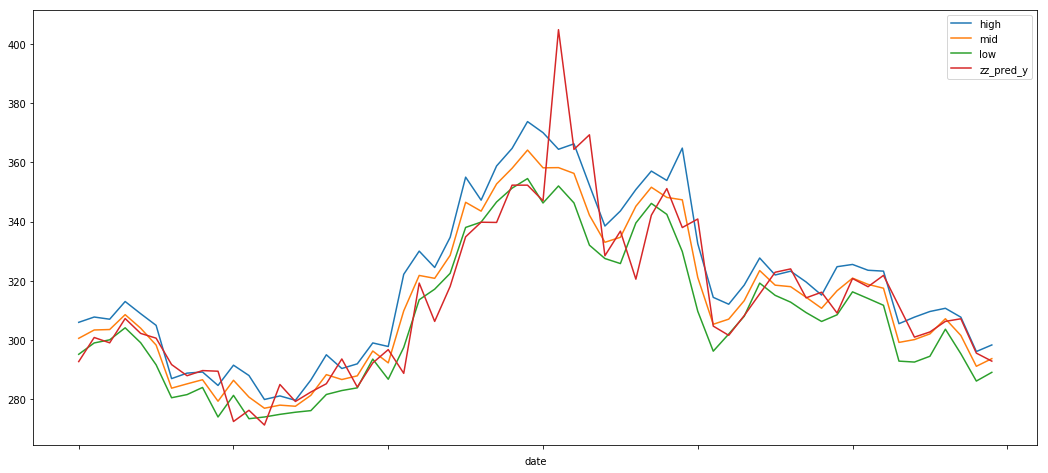

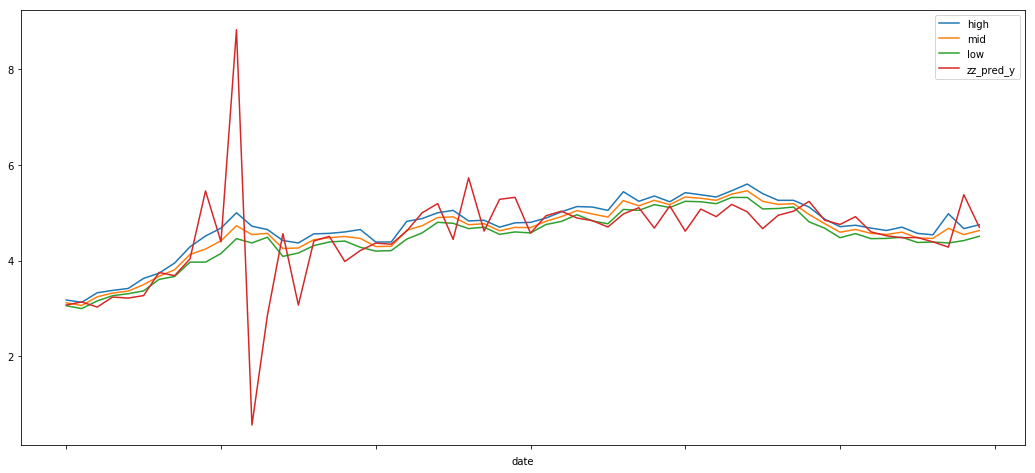

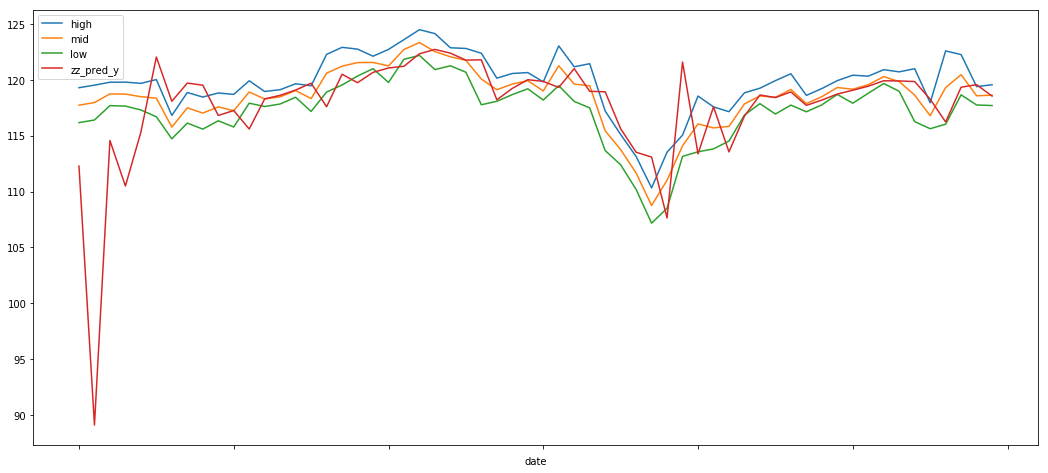

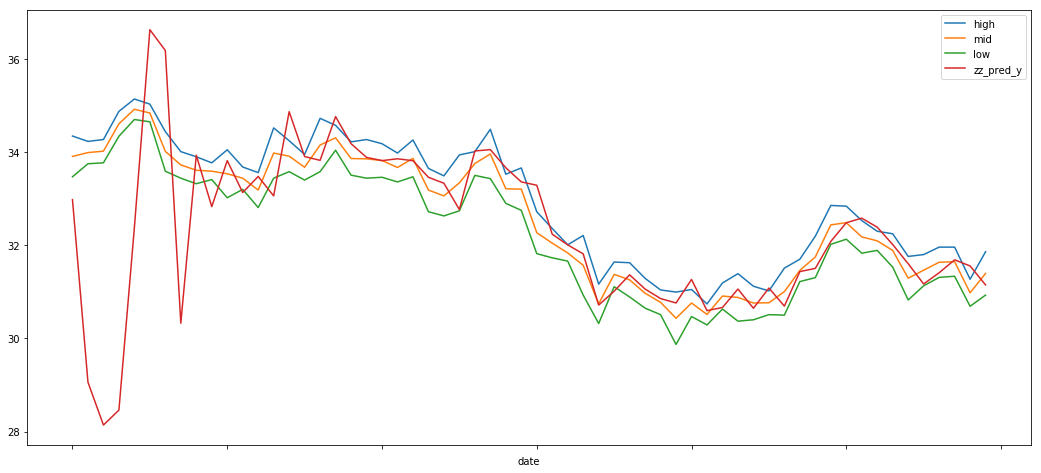

In [10]:
for symbol in ['T', 'F', 'GE', 'AAPL', 'TSLA', 'CHK', 'VAC', 'NRG']:
    analyze_symbol(symbol)

## Conclusion
> Certainly not going to make us millions but this does show some strengths and some areas of concerns when applying GPR to this specific direction. 
1. Nearly all graphs show one timeperiod in which the GPR seems to go off the reservation and predict some wild price swings. This is problematic if you were building a systematic trader around this signal. 
2. GPR does significantly better on more stable pricing structures like T (AT&T) vs CHK (Chesapeake Energy). This makes perfect intuitive sense and if we explored the deviation prediction, I'm sure the GPR would be self-aware of it's limitations here.
3. GPR does not seem to have a leaning in-terms of predicting above or below the channel, with each happening about the same amount of time. There might be a small trend-following delay here which shows a prefence for being 'below' on downward trending prices. This makes complete sense but is not easily exploitable.

Thanks for following along. Hope this was helpful, or at least interesting! 

---

## Scrap Code
yes, even I have to play around with some syntax ;-)

In [14]:
ol = GaussianProcessRegressor()
log_prices = np.exp(prices_enh)
ol.fit(
    log_prices[0:-2], log_prices.shift(-1)['close'][0:-2]
)
outs = ol.predict(log_prices[0:], return_std=True)
print(outs[0][-3:], "\n\n", outs[1][-3:])
prices_enh[-3:]

[279.94999998 211.59836059 265.36253082] 

 [1.00000115e-05 7.52356274e-01 6.94515570e-01]


,open,high,low,close,mid
date,,,,,
2018-07-27,5.647953,5.648340,5.636146,5.639848,5.642262
2018-07-30,5.640168,5.640807,5.632501,5.634611,5.636663
2018-07-31,5.637678,5.641978,5.636146,5.639528,5.639066
